In [0]:
import sys
import gym
import numpy as np
import random
import math
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

# 1.Q-learning

In [0]:
env = gym.make('CliffWalking-v0')

In [3]:
print(env.action_space)
print(env.observation_space)



Discrete(4)
Discrete(48)


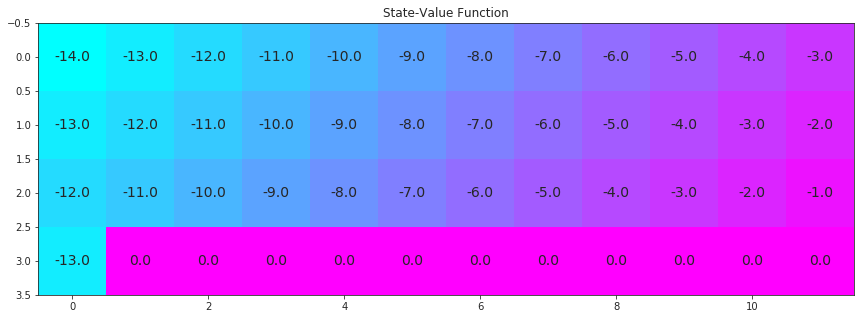

In [4]:
V_opt = np.zeros((4,12))
V_opt[0][0:13] = -np.arange(3, 15)[::-1]
V_opt[1][0:13] = -np.arange(3, 15)[::-1] + 1
V_opt[2][0:13] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)



In [0]:
def epsilon_greedy(Q, state, nA, eps):
  
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))

In [0]:
def update_Q(alpha, gamma, Q, state, action, reward, next_state=None):
   
    current = Q[state][action] 
    v = np.max(Q[next_state]) if next_state is not None else 0 
    target = reward + (gamma * v)               
    new_value = current + (alpha * (target - current)) 
    return new_value

In [0]:
def q_learning(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n                
    Q = defaultdict(lambda: np.zeros(nA)) 
    
    tmp_scores = deque(maxlen=plot_every)    
    avg_scores = deque(maxlen=num_episodes)   
    
    for i_episode in range(1, num_episodes+1):
        
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0                                             
        state = env.reset()                                   
        eps = 1.0 / i_episode                                  
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         
            next_state, reward, done, info = env.step(action)  
            score += reward                                    
            Q[state][action] = update_Q(alpha, gamma, Q,state, action, reward, next_state)        
            state = next_state                                 
            if done:
                tmp_scores.append(score)                       
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Episode 5000/5000

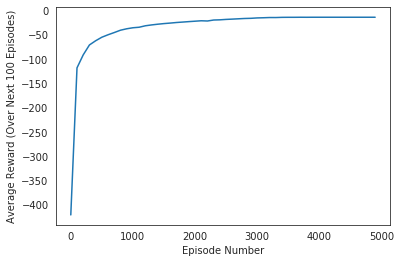

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  0  1  1  2  2  2  0]
 [ 0  1  1  1  1  1  1  1  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


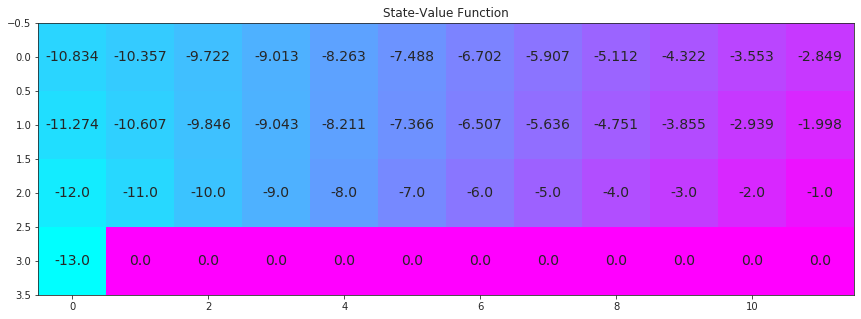

In [8]:

Q = q_learning(env, 5000, .01)
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)]).reshape((4,12))

check_test.run_check('td_control_check', policy)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy)


plot_values([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])

# 2.Monte Carlo Epsilon Greedy Policies

In [0]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
      
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

       
        episode = []
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        sa_in_episode = set([tuple((x[0], x[1])) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
          
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
           
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
      
    
    return Q, policy

In [12]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=20000, epsilon=0.1)

Episode 20000/20000.

**<span style="color: red;">PLEASE TRY AGAIN</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  2  3  0  1  1  1  1  2  3  1  2]
 [ 1  1  1  1  0  3  3  0  1  1  2  3]
 [ 3  3  1  0  0  0  0  0  3  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


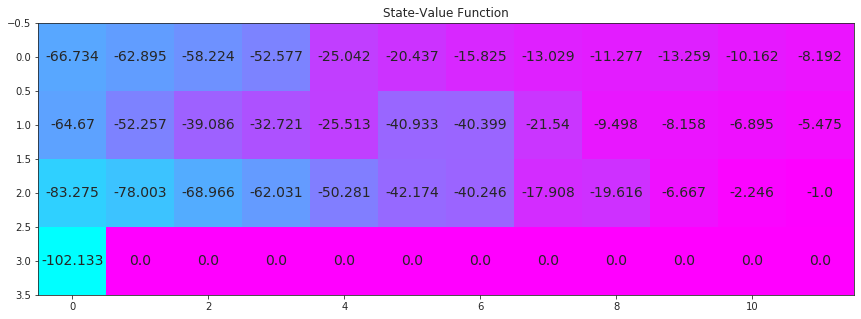

In [13]:
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)]).reshape((4,12))

check_test.run_check('td_control_check', policy)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy)


plot_values([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])